This notebook was created by Donna Faith Go.

In [1]:
import sys
!{sys.executable} -m pip install arch

   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---

In [32]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns
from typing import Tuple

# data gathering
import yfinance as yf

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# GARCH model
from arch import arch_model

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# GARCH on the PSEi

This notebook aims to do volatility clustering on the Philippine Stock Exchange Composite Index (PSEi) through the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model.

## Data Gathering

In [3]:
# getting closing prices for the 30 stocks with batching
start_date = '2013-01-01'# '2019-01-01'
end_date = '2026-01-01' #'2025-08-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     ['PSEI.PS'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('psei closing prices.pkl')

In [4]:
filepath = r'psei closing prices.pkl'
with open(filepath, 'rb') as f:
    pse_data = pickle.load(f)
print(pse_data.index[0])
print(pse_data.index[-1])

2013-01-02 00:00:00
2025-12-29 00:00:00


## Data Preprocessing

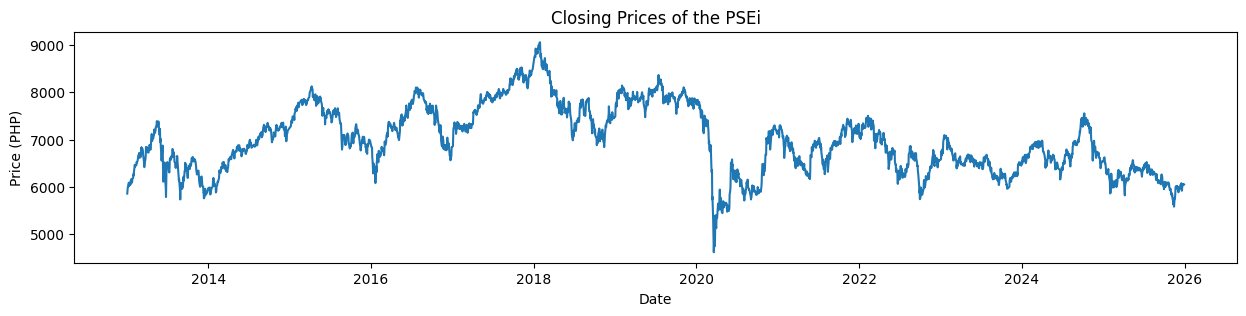

In [5]:
# plot the closing prices of the PSEi
plt.figure(figsize=(15, 3))
plt.plot(pse_data)
plt.xlabel('Date')
plt.ylabel('Price (PHP)')
plt.title('Closing Prices of the PSEi')
plt.show()

The data does not look stationary.

ADF Result: Stationary
KPSS Result: Stationary


C:\Users\Donna\AppData\Local\Temp\ipykernel_44612\1919743594.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(pse_data_values)[1]


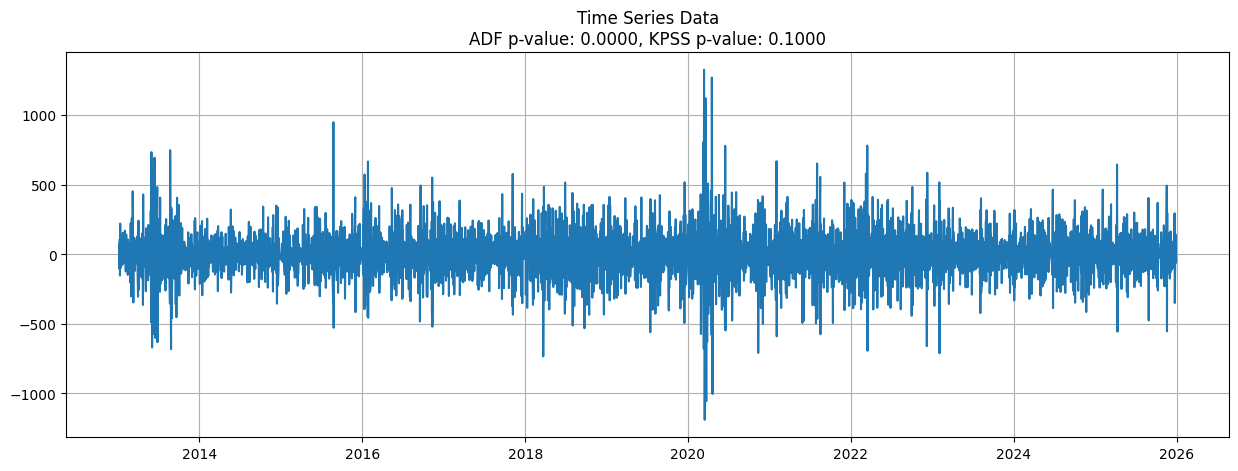

In [20]:
# turn to stationary
pse_data_diff = pse_data.diff(1)
pse_data_values = pse_data_diff['PSEI.PS'].dropna()

# checking for stationarity
p_value = 0.05
adf_res = adfuller(pse_data_values)[1]
kpss_res = kpss(pse_data_values)[1]

print("ADF Result:", "Stationary" if adf_res < p_value else "Not Stationary")
print("KPSS Result:", "Stationary" if kpss_res > p_value else "Not Stationary")

# plotting
plt.figure(figsize=(15, 5))
plt.plot(pse_data_values)
plt.title(f"Time Series Data\nADF p-value: {adf_res:.4f}, KPSS p-value: {kpss_res:.4f}")
plt.grid(True)
plt.show()

## Train, val, test

In [33]:
# train test split with lookback
def train_test_split(data: pd.Series, lookback: int = 12, test_size: int = 12) -> Tuple[pd.Series, pd.Series]:
    """Create a train-test split on your pd.Series data.

    Parameters:
    -----------
    data (pd.Series): The univariate time series provided
    lookback (int): The lookback periods to consider
    test_size (int): The length of the test set

    Returns:
    --------
    Tuple (pd.Series): The (train, test) pandas series generated
    """
    
    split = data.shape[0] - test_size
    return (
        data.iloc[:split],
        data.iloc[split - lookback: ]
    )

In [49]:
# determine number of points
test_pts = 0.2
test_size = int(np.floor(len(pse_data_values) * test_pts))

# splitting
train, test = train_test_split(
    pse_data_values, 5, int(np.floor(len(pse_data_values) * test_pts))
)

## Defining p, d, q

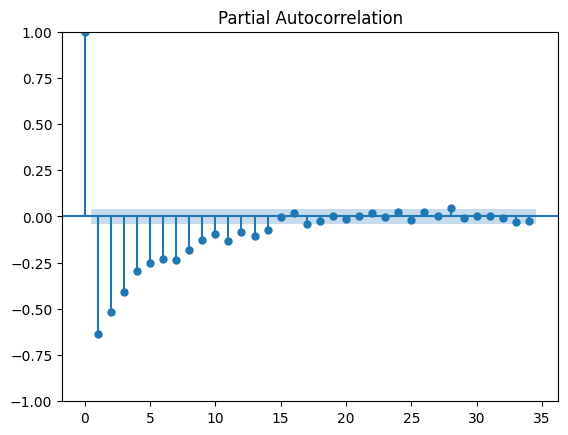

In [40]:
pacf_res = plot_pacf(train)

Based on the PACF plot, the best value for p is 15.

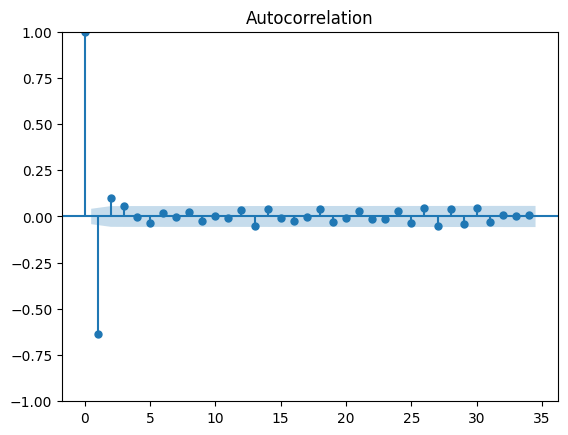

In [39]:
acf_res = plot_acf(train)

Based on the ACF plot, the best value for p is 2.

## GARCH Model

In [44]:
# creating the model
model = arch_model(train, p=15, q=2)
model_fit = model.fit()

C:\Users\Donna\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.869e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


Iteration:      1,   Func. Count:     21,   Neg. LLF: 14567.65394427082
Iteration:      2,   Func. Count:     42,   Neg. LLF: 14566.65224231084
Iteration:      3,   Func. Count:     63,   Neg. LLF: 15219.537696024254
Iteration:      4,   Func. Count:     84,   Neg. LLF: 14838.174450284072
Iteration:      5,   Func. Count:    105,   Neg. LLF: 15001.88352260707
Iteration:      6,   Func. Count:    127,   Neg. LLF: 14531.37888308954
Iteration:      7,   Func. Count:    148,   Neg. LLF: 14516.129557135426
Iteration:      8,   Func. Count:    169,   Neg. LLF: 14524.711542368219
Iteration:      9,   Func. Count:    190,   Neg. LLF: 14523.282611454855
Iteration:     10,   Func. Count:    212,   Neg. LLF: 14564.970377630008
Iteration:     11,   Func. Count:    233,   Neg. LLF: 14499.957160165952
Iteration:     12,   Func. Count:    254,   Neg. LLF: 14487.105736758625
Iteration:     13,   Func. Count:    275,   Neg. LLF: 14479.029836355992
Iteration:     14,   Func. Count:    296,   Neg. LLF: 1

In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                PSEI.PS   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14468.7
Distribution:                  Normal   AIC:                           28975.5
Method:            Maximum Likelihood   BIC:                           29083.8
                                        No. Observations:                 2214
Date:                Tue, Jan 13 2026   Df Residuals:                     2213
Time:                        14:53:25   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.7354      2.246      0.773      0.440 [ -2.668,  6.138]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega       7642.2935   3775.691      2.024  4.296e-02  [2.421e+02,1.504e+04]
alpha[1]       0.5574  4.236e-02     13.157  1.556e-39      [  0.474,  0.640]
alpha[2]       0.0145      0.314  4.602e-02      0.963      [ -0.601,  0.630]
alpha[3]       0.0381      0.271      0.141      0.888      [ -0.493,  0.569]
alpha[4]       0.0173  3.146e-02      0.549      0.583 [-4.438e-02,7.893e-02]
alpha[5]       0.0000  2.254e-02      0.000      1.000 [-4.419e-02,4.419e-02]
alpha[6]       0.0000  2.940e-02      0.000      1.000 [-5.762e-02,5.762e-02]
alpha[7]       0.0528  2.713e-02      1.946  5.160e-02   [-3.660e-04,  0.106]
alpha[8]       0.0000  4.013e-02      0.000      1.000 [-7.866e-02,7.866e-02]
alpha[9]       0.0387  3.672e-02      1.054      0.292   [-3.325e-02,  0.111]
alpha[10]      0.0435  3.343e-02      1.302      0.193   [-2.199e-02,  0.109]
alpha[11]  2.5120e-03  3.181e-02  7.896e-02      0.937 [-5.984e-02,6.486e-02]
alpha[12]      0.0386  2.822e-02      1.366      0.172 [-1.676e-02,9.387e-02]
alpha[13]      0.0000  3.745e-02      0.000      1.000 [-7.340e-02,7.340e-02]
alpha[14]  8.7817e-03  2.156e-02      0.407      0.684 [-3.347e-02,5.104e-02]
alpha[15]      0.0167  1.848e-02      0.902      0.367 [-1.954e-02,5.288e-02]
beta[1]    3.7128e-07      0.565  6.567e-07      1.000      [ -1.108,  1.108]
beta[2]    6.7563e-07      0.484  1.396e-06      1.000      [ -0.949,  0.949]
=============================================================================

Covariance estimator: robust
"""

In [58]:
predictions = model_fit.forecast(horizon = test_size)
preds = predictions.variance.values[-1, :]
preds = pd.Series(preds, index=pse_data_values[-test_size:].index)

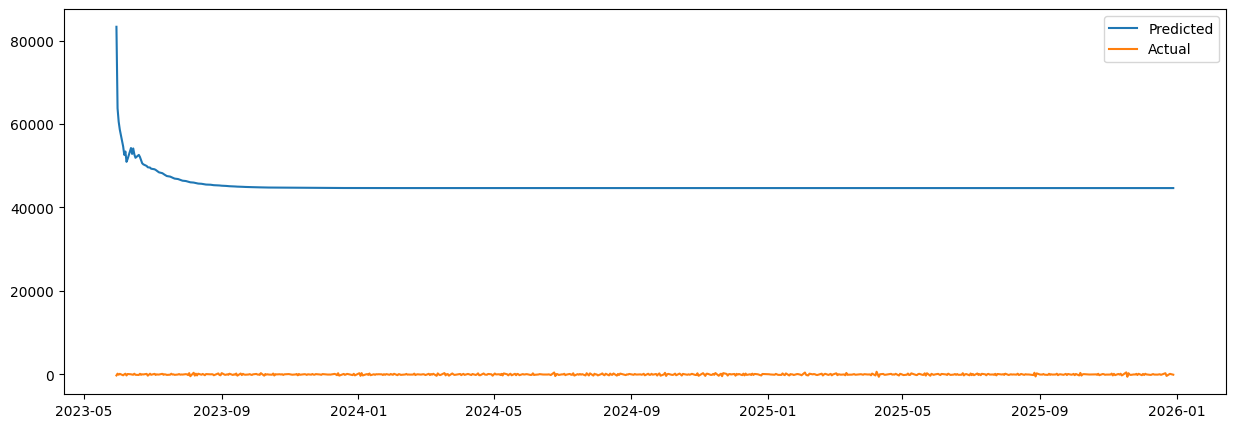

In [59]:
plt.figure(figsize=(15, 5))
plt.plot(preds, label='Predicted')
plt.plot(pse_data_values[-test_size:], label='Actual')
plt.legend()
plt.show()